<a href="https://colab.research.google.com/github/ShanmugapriyanManoharan/OpenCV-Deep-Learning/blob/master/Shape_%26_Color_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow

In [0]:
class ColorLabeler:
	def __init__(self):
		# initialize the colors dictionary
		colors = OrderedDict({
			"red": (255, 0, 0),
			"green": (0, 255, 0),
			"blue": (0, 0, 255)})

		# allocate memory for the CIE L*a*b* image, then initialize color names
    #url: https://en.wikipedia.org/wiki/CIELAB_color_space
		self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
		self.colorNames = []

		# loop over the colors dictionary
		for (i, (name, rgb)) in enumerate(colors.items()):
			# update the L*a*b* array (Numpy array) and the color names list
			self.lab[i] = rgb
			self.colorNames.append(name)

		# convert the L*a*b* array from the RGB color space
		# to L*a*b*
		self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)

	def label(self, image, c):
		# construct a mask for the contour, then compute the
		# average L*a*b* value for the masked region
		mask = np.zeros(image.shape[:2], dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)
		mask = cv2.erode(mask, None, iterations=2)
		mean = cv2.mean(image, mask=mask)[:3]

		# initialize the minimum distance found thus far
		minDist = (np.inf, None)

		# loop over the known L*a*b* color values
		for (i, row) in enumerate(self.lab):
			# compute the distance between the current L*a*b*
			# color value and the mean of the image
			d = dist.euclidean(row[0], mean)

			# if the distance is smaller than the current distance,
			# then update the bookkeeping variable
			if d < minDist[0]:
				minDist = (d, i)

		# return the name of the color with the smallest distance
		return self.colorNames[minDist[1]]

In [0]:
class ShapeDetector:
	def __init__(self):
		pass

	def detect(self, c):
		# Initialize the name of shape and approximate the contour
		shape = "unidentified"
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.04 * peri, True)

		# If vertices = 3, then triangle
		if len(approx) == 3:
			shape = "triangle"

		# If vertices = 4, then rectangle or square
		elif len(approx) == 4:
			# Compute aspect ratio using bounding box of the contour
			(x, y, w, h) = cv2.boundingRect(approx)
			ar = w / float(h)

			# If aspect ratio near to 1, then shape is square. otherwise rectangle
			shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

		# If vertices =5, then pentagon
		elif len(approx) == 5:
			shape = "pentagon"

    # If vertices =6, then Hexagon
		elif len(approx) == 6:
			shape = "Hexagon"

		# Else, the shape is assumed to be circle
		else:
			shape = "circle"

		# return the name of the shape
		return shape

In [0]:
# load the image and resize using imutils to a smaller factor so that the shapes can be approximated better
image = cv2.imread("shapes.png")
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])

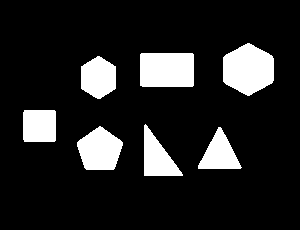

In [28]:
# Blur and Grayscale the image and threshold it and the L*a*b* color spaces
blurred = cv2.GaussianBlur(resized, (5, 5), 0)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
cv2_imshow(thresh)

In [0]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [0]:
# initialize the shape detector and color labeler
sd = ShapeDetector()
cl = ColorLabeler()

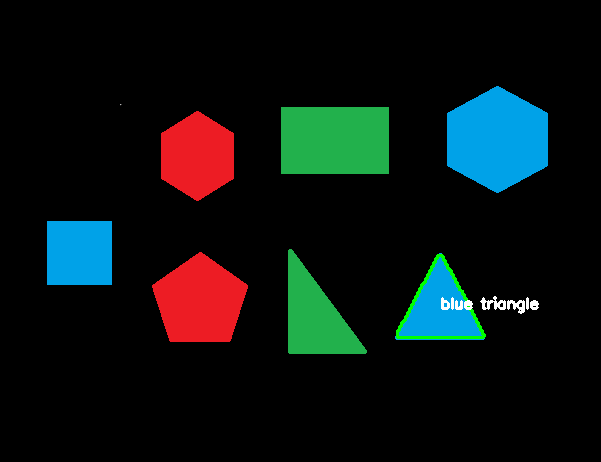

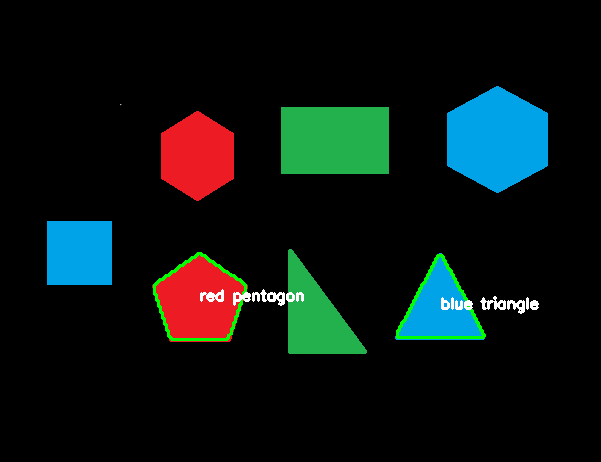

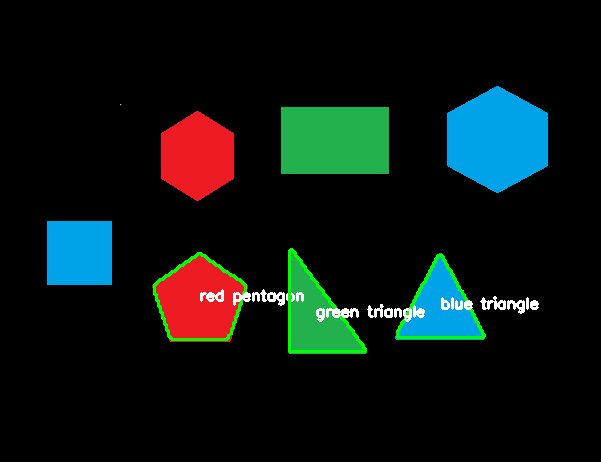

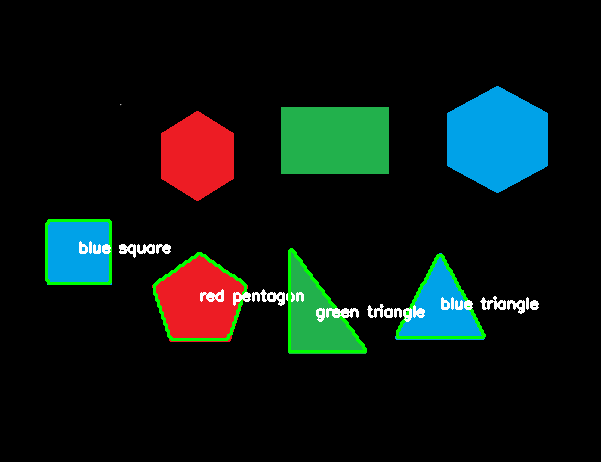

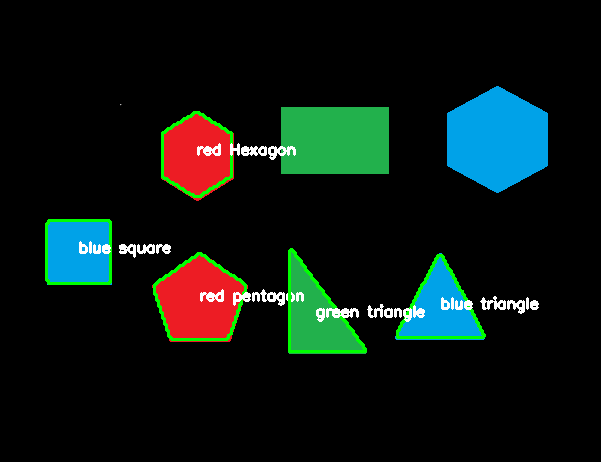

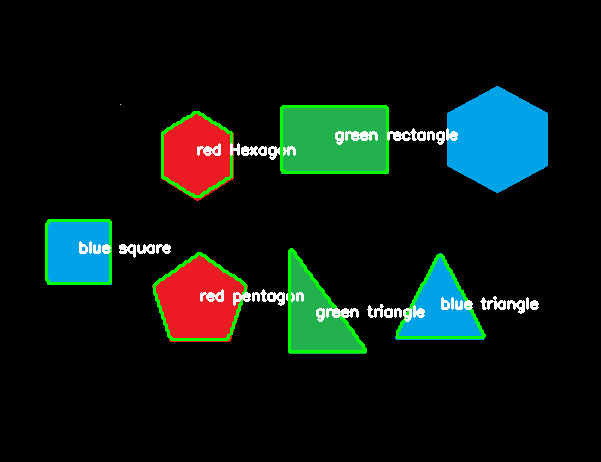

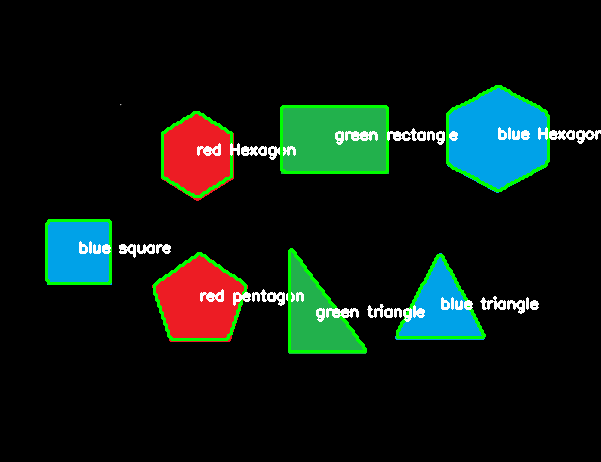

In [27]:
# loop over the contours
for c in cnts:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int((M["m10"] / M["m00"]) * ratio)
	cY = int((M["m01"] / M["m00"]) * ratio)

	# detect the shape of the contour and label the color
	shape = sd.detect(c)
	color = cl.label(lab, c)

	# multiply the contour (x, y)-coordinates by the resize ratio,
	# then draw the contours and the name of the shape and labeled
	# color on the image
	c = c.astype("float")
	c *= ratio
	c = c.astype("int")
	text = "{} {}".format(color, shape)
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
	cv2.putText(image, text, (cX, cY),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

	# show the output image
	cv2_imshow(image)